# 第5章 次元削減でデータを圧縮する

## ゴール
次元削減の手法として、特徴抽出がある。本章では特徴抽出で代表的な以下の項目について理解する。
- 教師なしデータ圧縮での主成分分析（PCA）
- クラスの分離を最大化する教師あり次元削減方としての線形判別分析（LDA）
- カーネル主成分分析（KPCA）による非線形次元削減

## 主成分分析

### アプローチ
1. $d$ 次元のデータセットを標準化する
2. 標準化したデータセットの共分散行列を作成する
3. 共分散行列を固有ベクトルと固有値に分散する
4. 固有値を降順でソートすることで、対応する固有ベクトルをランク付けする
5. 最も大きい $k$ 個の固有値に対応する $k$ 個の固有ベクトルを選択する
6. 上位 $k$ 個の固有ベクトルから射影行列 $\boldsymbol{W}$を作成する
7. 射影行列 $\boldsymbol{W}$ を使って $d$ 次元の入力データセット $\boldsymbol{X}$ を変換し、新しい $k$ 次元の特徴部分空間を取得する

#### データの用意
- Wine データセットを読み込む（特徴量: 13次元、クラスラベル: 3）
- 訓練データとテストデータを7:3で分割する
- 分散が1になるように標準化する

In [36]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_wine()

print('[data]')
print('\n- features: ', len(data.feature_names))
for feature in data.feature_names:
    print('  - ', feature)
print('\n- targets: ', len(data.target_names))
for target in data.target_names:
    print('  - ', target)

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

[data]

- features:  13
  -  alcohol
  -  malic_acid
  -  ash
  -  alcalinity_of_ash
  -  magnesium
  -  total_phenols
  -  flavanoids
  -  nonflavanoid_phenols
  -  proanthocyanins
  -  color_intensity
  -  hue
  -  od280/od315_of_diluted_wines
  -  proline

- targets:  3
  -  class_0
  -  class_1
  -  class_2


#### 共分散行列を作成し、固有値を取得

共分散行列の固有ベクトルが主成分（分散が最大となる方向）を表し、対応する固有値はそれらの大きさを定義する。
- 標準化した訓練データを用いて、$13\times13$次元の共分散行列を作成
- 共分散行列から、13個の固有値と13本の固有ベクトルを得る。

In [64]:
import numpy as np


cov_mat = np.cov(X_train_std.T) # (13, 13)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)  # (13,), (13, 13) 
print('Eigen values[0]: ', eigen_vals[0])
print('Eigen vectors[0]: ', eigen_vecs[0])

Eigen values[0]:  4.8427453156558915
Eigen vectors[0]:  [-0.13724218  0.50303478 -0.13774873 -0.0032961  -0.29062523  0.29909685
  0.07905293 -0.36817641 -0.39837702 -0.09448698  0.37463888 -0.12783451
  0.26283426]


#### 分散説明率をプロット
データに含まれる大半の情報（分散）を含んでいる固有ベクトル（主成分）だけを選択する。
固有値は固有ベクトルの大きさを表すため、大きいものから順に降順で並べ替える必要がある。

固有値$\lambda_j$の分散説明率は以下で定義される。固有値の合計に対する固有値$\lambda_j$の割合を意味する。

$$
\frac{\lambda_j}{\sum^d_{i=1}\lambda_i}
$$

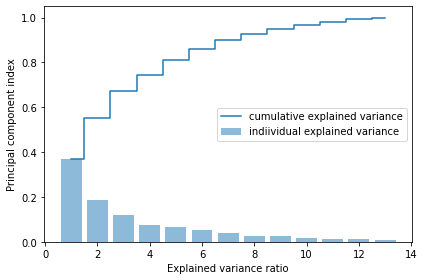

In [65]:
# 固有値の合計
total = sum(eigen_vals)
# 分散説明率
var_exp = [(i / total) for i in sorted(eigen_vals, reverse=True)]
# 分散説明率の累積和
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='indiividual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.xlabel('Explained variance ratio')
plt.ylabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### 特徴変換

- 固有値の大きい順に (固有値, 固有ベクトル) のペアを並び替える
- 上位$k$個の固有ベクトルから射影行列$\boldsymbol{W}$を作成する
- 射影行列を利用して、$\boldsymbol{x}\in \mathbb{R}^{13}$を新しい特徴量からなる2次元のベクトル$\boldsymbol{x'}\in\mathbb{R}^2$を作成する

$$
\boldsymbol{x'} = \boldsymbol{x}\boldsymbol{W}
$$

In [98]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
print('Eigen Pairs[0] \n', eigen_pairs[0])

# 固有値の降順に並び替え
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

k = 2
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('\nMatrix W: \n', w)

X_train_pca = X_train_std.dot(w) # (124, 2)

print('\nX_train_pca.shape: ', X_train_pca.shape)

Eigen Pairs[0] 
 (4.8427453156558915, array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651]))

Matrix W: 
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]

X_train_pca.shape:  (124, 2)


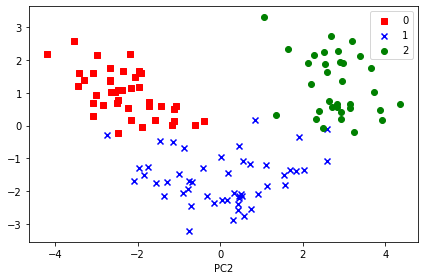

In [105]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m)

plt.xlabel('PC1')
plt.xlabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### scikit-learn による主成分分析
- transformer クラスの一つである`PCA`クラスを利用する
- PCAを適用する前に、訓練データ・テストデータの標準化までは済ませておく

In [119]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    marker=markers[idx], 
                    label=cl)

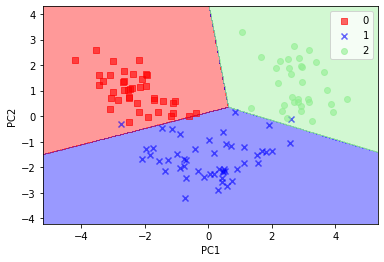

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# PCAを適用する前に、事前に訓練データ、テストデータの標準化までは済ませておく

k = 2 # 主成分数 n_components を指定

pca = PCA(n_components=k)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()